In [0]:
import numpy as np 
import pandas as pd
import json
import os
from tqdm import tqdm
import re
import nltk

from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download("stopwords")
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess

import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from sklearn.decomposition import LatentDirichletAllocation as LDA

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/TianyiYu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/TianyiYu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Import Data

The json files are read to obtain the full text data of the papers. Full text data is used for some parts of the analysis as sometimes abstracts are too brief to contain much information. In order to be consistent, I will only use the abstracts of those papers with full text.

The data read from json file is provided by the course instructor and is downloaded from: https://drive.google.com/drive/folders/161uYI2GwTXyajJti3SkP6N4R3DsiB3jq

In [0]:
filepaths=["CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv",
"CORD-19-research-challenge/comm_use_subset/comm_use_subset",
"CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset",
"CORD-19-research-challenge/custom_license/custom_license"]
data_=list()
for filepath in filepaths:
    for filename in tqdm(os.listdir(filepath)):

        x=str(filepath)+'/'+str(filename)

        with open(x) as file:
            data=json.loads(file.read())

        #take out the data from the json format
        title_text = data['metadata']['title'] 
        #title_text=""
        #for text in title_:
            #title_text+=text['text']+" "
        
        abstract=data['abstract']
        abstract_text=""
        for text in abstract:
            abstract_text+=text['text']+" "
        
        body_text=data['body_text']
        full_text=""
        for text in body_text:
            full_text+=text['text']+" "
        back_matter=data['back_matter']
        #store everything to a dataframe
        data_.append([title_text,abstract_text,full_text])

df=pd.DataFrame(data_,columns=['title','abstract','full_text'])

100%|██████████| 20657/20657 [00:32<00:00, 636.18it/s]


In [0]:
df.head()

,title,abstract,full_text
0,Multimerization of HIV-1 integrase hinges on c...,New anti-AIDS treatments must be continually d...,"In the absence of a curative treatment, the hi..."
1,Time-varying transmission dynamics of Novel Co...,Rationale: Several studies have estimated basi...,"Eighteen years ago, severe acute respiratory s..."
2,p53 is not necessary for DUX4 pathology,Summary Statement: DUX4 is thought to mediate ...,Facioscapulohumeral muscular dystrophy (FSHD) ...
3,Virological assessment of hospitalized cases o...,"emerged in late 2019 1,2 . Initial outbreaks i...",Pharyngeal virus shedding was very high during...
4,Potential impact of seasonal forcing on a SARS...,A novel coronavirus (SARS-CoV-2) first detecte...,(2.2 with 90% high density interval 1.4-3.8 (R...


# 1.0 Data Cleaning

In this section, the abstract and full text sections are cleaned for further analysis.

In [0]:
#covid_synonyms=['coronavirus','Covid-19','Corona virus','COVID 19','covid-19', 'Coronavirus', 'cov-2',  'hcov', '2019-ncov']
#df = df[df['abstract'].str.contains('|'.join(covid_synonyms))]

In [0]:
# drop duplicates
df = df.drop_duplicates(subset='abstract', keep="first")

# drop NANs 
df=df.dropna()

# convert abstracts and full_text to lowercase
df['abstract_cleaned'] = df['abstract'].str.lower()
df['full_text_cleaned'] = df['full_text'].str.lower()

In [0]:
# remove punctuation
def remove_nonletter(text):
    """
    matching anything that is not in the a-z, A-Z and white space set, replace with white space
    """
    text=re.sub(r'[^a-zA-Z0-9 ]+', ' ', text)
    return text

In [0]:
# remove white spaces
def remove_ws(text):
    """
    Removing extra whitespace, make all text lower case, and remove trailing and leading white spaces
    """
    text=re.sub(r'\s+', ' ', text)
    return text

In [0]:
df['abstract_cleaned'] = df['abstract_cleaned'].apply(remove_nonletter)

In [0]:
df['abstract_cleaned'] = df['abstract_cleaned'].apply(remove_ws)

In [0]:
df['full_text_cleaned'] = df['full_text_cleaned'].apply(remove_nonletter)

In [0]:
df['full_text_cleaned'] = df['full_text_cleaned'].apply(remove_ws)

In [0]:
df.head()

,title,abstract,full_text,abstract_cleaned,full_text_cleaned
0,Multimerization of HIV-1 integrase hinges on c...,New anti-AIDS treatments must be continually d...,"In the absence of a curative treatment, the hi...",new anti aids treatments must be continually d...,in the absence of a curative treatment the hig...
1,Time-varying transmission dynamics of Novel Co...,Rationale: Several studies have estimated basi...,"Eighteen years ago, severe acute respiratory s...",rationale several studies have estimated basic...,eighteen years ago severe acute respiratory sy...
2,p53 is not necessary for DUX4 pathology,Summary Statement: DUX4 is thought to mediate ...,Facioscapulohumeral muscular dystrophy (FSHD) ...,summary statement dux4 is thought to mediate c...,facioscapulohumeral muscular dystrophy fshd af...
3,Virological assessment of hospitalized cases o...,"emerged in late 2019 1,2 . Initial outbreaks i...",Pharyngeal virus shedding was very high during...,emerged in late 2019 1 2 initial outbreaks in ...,pharyngeal virus shedding was very high during...
4,Potential impact of seasonal forcing on a SARS...,A novel coronavirus (SARS-CoV-2) first detecte...,(2.2 with 90% high density interval 1.4-3.8 (R...,a novel coronavirus sars cov 2 first detected ...,2 2 with 90 high density interval 1 4 3 8 rio...


## Remove Stop Words

In this section, stopwords in the ntlk set are removed. Additionally, it is expected that science research papers have some additional stopwords and these are revealed by word frequencies. Some words are manually added to the stopword list in this way.

In [0]:
stop_words=set(stopwords.words('english'))

In [0]:
def remove_stopwords(text):
    words = text.split()
    new_text = [word for word in words if word not in stop_words]
    return ' '.join(new_text)

In [0]:
df['abstract_cleaned'] = df['abstract_cleaned'].apply(remove_stopwords)

In [0]:
df['full_text_cleaned'] = df['full_text_cleaned'].apply(remove_stopwords)

In [0]:
# This step is to generate the most frequent used words and these words are manually added to the stop word list
#pd.Series(' '.join(df.full_text_cleaned).split()).value_counts()[0:50]

In [0]:
# additional stopwords
stop_words = ['et','al','also','using','used','study','may','fig','data','results','figure',
                  'studies','specific','however','expression','de','shown','based','found','could',
                  'table','observed','cases','use','including','c','n','e','p','b','g','l','h',
             'la','le','de','en','une','ce','hajj','abstract','publisher','cc']

In [0]:
df['abstract_cleaned'] = df['abstract_cleaned'].apply(remove_stopwords)

In [0]:
df['full_text_cleaned'] = df['full_text_cleaned'].apply(remove_stopwords)

## Lemmatization

In [0]:
def lemmatization(text):
    words = word_tokenize(text)
    new_text = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(new_text)

In [0]:
df['abstract_cleaned'] = df['abstract_cleaned'].apply(lemmatization)

In [0]:
df['full_text_cleaned'] = df['full_text_cleaned'].apply(lemmatization)

# 2.0 Data Visualization and Exploratory Data Analysis

In this section, a series of graphs are plotted to visualize some trends in the data.

## Word Cloud for Abstract and Full Text

First of all, two world clouds are generated fro the abstract and full text dataset according to the corresponding frequency of each word. 

For the word cloud of abstracts, some most frequent words are ncp, dux4 sars, rejection, lung, formation, time varying, etc. NCP stands for Novel Coronavirus Pneumonia which is a temporary name for covid-19. Dux4 is Double Homeobox 4 and is a protein coding gene. 

For the word cloud of full texts, the most frequent words are cell, antibody, coli, infection, rejection, acute, peptide, diarrhea, etc, representing some aspects of the coronavirus.

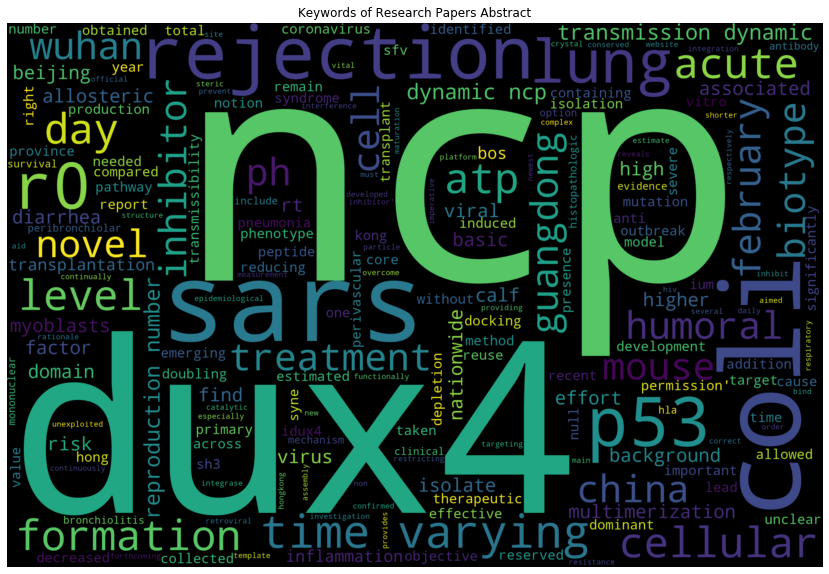

In [0]:
text = df.abstract_cleaned.values
abstract_wordcloud = WordCloud(width = 3000, height = 2000, background_color="black").generate(str(text))

plt.figure(figsize=(20,10))
plt.imshow(abstract_wordcloud, interpolation='bilinear')
plt.title('Keywords of Research Papers Abstract')
plt.axis("off")
plt.show()

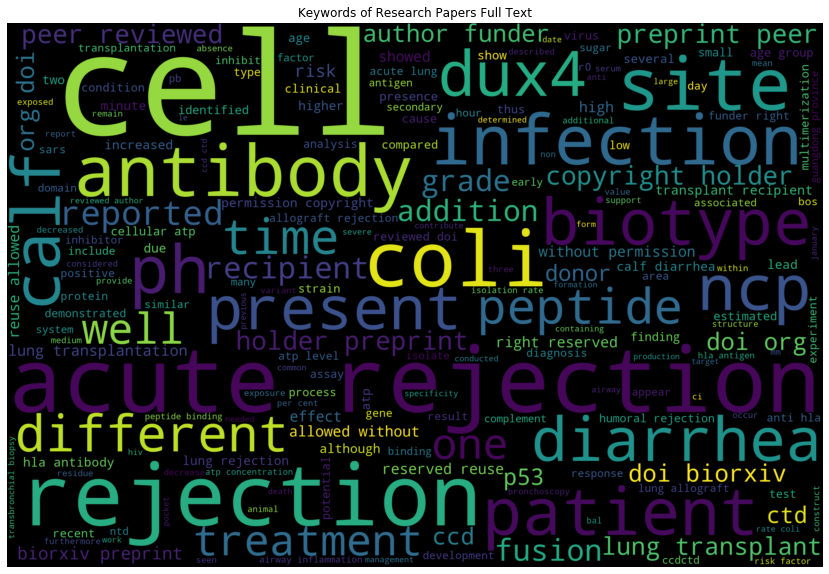

In [0]:
text = df.full_text_cleaned.values
full_text_wordcloud = WordCloud(width = 3000, height = 2000, background_color="black").generate(str(text))

plt.figure(figsize=(20,10))
plt.imshow(full_text_wordcloud, interpolation='bilinear')
plt.title('Keywords of Research Papers Full Text')
plt.axis("off")
plt.show()

## Incubation Period

The incubation period is collected from the full text dataset and the distribution is plotted. It is clear from the graph that most of the researchers conclude the incubation period to be between 0 and 20 days. The most popular deduction would be between 0 and 10 days. However, longer incubation periods do exist. The incubation can take up to months.

In [0]:
synonyms=[]
for syn in wordnet.synsets("incubation"):
    for word in syn.lemma_names():
        if word not in synonyms:
            synonyms.append(word)
#after get a list of synonyms of 'incubation', create a datafram that all articles inside it should mentioned 'incubation'
incubation_df=df[df['full_text_cleaned'].str.contains('|'.join(synonyms))]

In [0]:
incubation_df.head()

,title,abstract,full_text,abstract_cleaned,full_text_cleaned
1,Time-varying transmission dynamics of Novel Co...,Rationale: Several studies have estimated basi...,"Eighteen years ago, severe acute respiratory s...",rationale several estimated basic production n...,eighteen year ago severe acute respiratory syn...
4,Potential impact of seasonal forcing on a SARS...,A novel coronavirus (SARS-CoV-2) first detecte...,(2.2 with 90% high density interval 1.4-3.8 (R...,novel coronavirus sars cov 2 first detected wu...,2 2 90 high density interval 1 4 3 8 riou alth...
13,A Multiscale and Comparative Model for Recepto...,The respiratory syndrome caused by a new type ...,The coronavirus disease 2019 has emerged at th...,respiratory syndrome caused new type coronavir...,coronavirus disease 2019 emerged end year 2019...
15,High COVID-19 incidence among Norwegian travel...,,"On February 27th, three cases of COVID-19 were...",,february 27th three covid 19 reported among no...
21,Real-Time Estimation of the Risk of Death from...,The exported cases of 2019 novel coronavirus i...,"Since 8 December, 2019, clusters of pneumonia ...",exported 2019 novel coronavirus infection conf...,since 8 december 2019 cluster pneumonia unknow...


In [0]:
text=incubation_df['full_text_cleaned'].values

In [0]:
keyword_time = list()
for t in text:
    for sentences in t.split(". "):
        if 	'incubation' in sentences:
            single_day = re.findall(r" \d{1,2} day", sentences)
            
            if len(single_day) == 1:
                num = single_day[0].split(" ")
                keyword_time.append(float(num[1]))

Text(0.5, 0, 'Incubation Time')

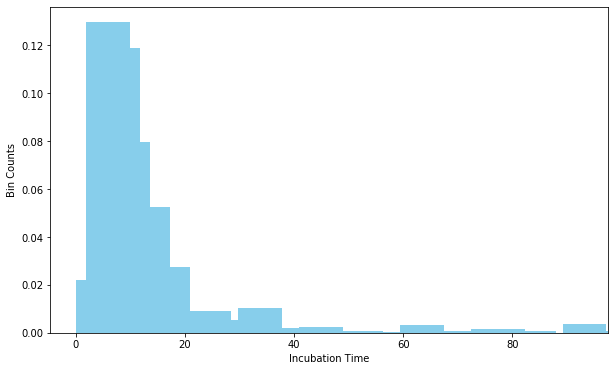

In [0]:
plt.figure(figsize=(10,6))
plt.hist(keyword_time, bins = 50, density = True,  width = 8.0, color = 'skyblue')
plt.ylabel("Bin Counts")
plt.xlabel("Incubation Time")

## Affected Organs

In this section, the most affected organs are obtained by exploring their frequency of mentions in the full text data. The 13 organs in the graph are selected because more than 5% of the paper mentioned them as being affected. The 3 organs with most frequent mentions are ear, pons and liver.

In [0]:
organs = ['mouth','teeth','tongue','salivary glands','parotid glands','submandibular glands','sublingual glands','pharynx',
               'esophagus','stomach','small intestine','duodenum','Jejunum','ileum','large intestine','liver','Gallbladder',
               'mesentery','pancreas','anal canal and anus','blood cells','respiratory system','nasal cavity','pharynx','larynx',
               'trachea','bronchi','lungs','diaphragm','Urinary system','kidneys','Ureter','bladder','Urethra','reproductive organs',
               'ovaries','Fallopian tubes','Uterus','vagina','vulva','clitoris','placenta','testes','epididymis','vas deferens',
               'seminal vesicles','prostate','bulbourethral glands','penis','scrotum','endocrine system','pituitary gland','pineal gland',
               'thyroid gland','parathyroid glands','adrenal glands','pancreas','circulatory system','Heart','patent Foramen ovale','arteries',
               'veins','capillaries','lymphatic system','lymphatic vessel','lymph node','bone marrow','thymus','spleen','tonsils','interstitium',
               'nervous system','brain','cerebrum','cerebral hemispheres','diencephalon','the brainstem','midbrain','pons','medulla oblongata',
               'cerebellum','the spinal cord','the ventricular system','choroid plexus','peripheral nervous system','nerves',
               'cranial nerves','spinal nerves','Ganglia','enteric nervous system','sensory organs','eye','cornea','iris','ciliary body',
               'lens','retina','ear','outer ear','earlobe','eardrum','middle ear','ossicles','inner ear','cochlea','vestibule of the ear',
               'semicircular canals','olfactory epithelium','tongue','taste buds','integumentary system','mammary glands','skin','subcutaneous tissue']

In [0]:
first_orga = df["full_text_cleaned"].str.contains(organs[0]).astype('uint8')
orga_df = pd.DataFrame(data=[first_orga]).T

for i in range(len(organs)-1):
    orga_col = df["full_text_cleaned"].str.contains(organs[i+1]).astype('uint8')
    orga_col_df = pd.DataFrame(data=[orga_col]).T
    orga_df = pd.concat([orga_df,orga_col_df], axis=1)

In [0]:
orga_df.columns = organs
orga_df.head()

,mouth,teeth,tongue,salivary glands,parotid glands,submandibular glands,sublingual glands,pharynx,esophagus,stomach,...,cochlea,vestibule of the ear,semicircular canals,olfactory epithelium,tongue,taste buds,integumentary system,mammary glands,skin,subcutaneous tissue
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
orga_df = orga_df.loc[:, (orga_df==0).mean() < .95]
orga_df

,mouth,liver,trachea,bronchi,lymph node,bone marrow,spleen,nervous system,brain,pons,eye,ear,skin
0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,1,1,1,1
3,0,0,0,0,0,0,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33366,0,1,0,0,1,0,1,0,0,1,1,1,0
33369,0,0,0,0,0,0,0,0,0,1,1,1,0
33371,0,1,0,0,0,0,0,0,0,0,1,1,0
33372,0,0,0,0,0,0,0,0,0,0,0,1,0


In [0]:
orga_df_plot = orga_df.apply(pd.value_counts)

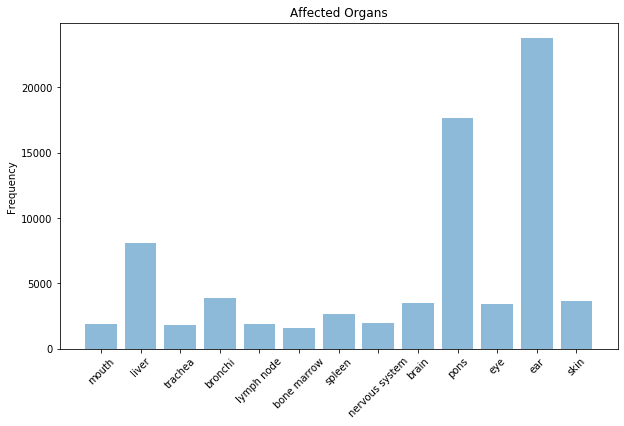

In [0]:
plt.figure(figsize=(10,6))
plt.bar(orga_df_plot.columns,orga_df_plot.iloc[1], align='center', alpha=0.5)
plt.xticks(orga_df_plot.columns,rotation=45)
plt.ylabel('Frequency')
plt.title('Affected Organs')

plt.show()

# 3.0 Model Implementation

In this section, the analysis of transmission and symptpms would be conducted using two different models:


1.   Latent Dirichlet Allocation (LDA) Model
2.   Apriori Algorithm

Both of them are unsupervised maching learning models as no known output is available from the dataset.



## Transmission Analysis Using Latent Dirichlet Allocation (LDA) Model

Unlike the analysis of affected organs and symptoms, a set of keywords is not defined prior to the analysis. In this case, we would like the model to do the clustering and the keyword extraction together. This introduces the concept of Topic Modeling.

**Topic Modeling** is a method for unsupervised classification of documents, similar to clustering on numeric data, which finds some natural groups of items (topics) even when we’re not sure what we’re looking for. Topic modeling provides methods for automatically organizing, understanding, searching, and summarizing large electronic archives. It can help to discover the hidden themes in the collection, to classify the documents into the discovered themes and to use the classification to organize/summarize/search the documents.

**Latent Dirichlet Allocation (LDA)** is one of the most popular topic modeling methods. Each document is made up of various words, and each topic also has various words belonging to it. The aim of LDA is to find topics a document belongs to, based on the words in it. 

### Prepare Dataset

In [0]:
trans_df = df[df['abstract_cleaned'].str.contains('transmission')]

In [0]:
trans_df.head()

,title,abstract,full_text,abstract_cleaned,full_text_cleaned
1,Time-varying transmission dynamics of Novel Co...,Rationale: Several studies have estimated basi...,"Eighteen years ago, severe acute respiratory s...",rationale several estimated basic production n...,eighteen year ago severe acute respiratory syn...
3,Virological assessment of hospitalized cases o...,"emerged in late 2019 1,2 . Initial outbreaks i...",Pharyngeal virus shedding was very high during...,emerged late 2019 1 2 initial outbreak china i...,pharyngeal virus shedding high first week symp...
4,Potential impact of seasonal forcing on a SARS...,A novel coronavirus (SARS-CoV-2) first detecte...,(2.2 with 90% high density interval 1.4-3.8 (R...,novel coronavirus sars cov 2 first detected wu...,2 2 90 high density interval 1 4 3 8 riou alth...
10,Projecting the end of the Zika virus epidemic ...,International Concern following a cluster of a...,"Starting as early as 2013, 1 has since spread ...",international concern following cluster associ...,starting early 2013 1 since spread 49 country ...
11,Relations of parameters for describing the epi...,In order to quantitatively characterize the ep...,We reported the understanding of the present s...,order quantitatively characterize epidemic cov...,reported understanding present status forecast...


### Prepare TD-IDF Features

In [0]:
tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2,max_features=1024)
tfidf_data = tfidf_vect.fit_transform(trans_df['abstract_cleaned'].values)

### Implementation of LDA Model

In [0]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
#Tweak the two parameters below
number_topics = 10
number_words = 10
#Create and fit the LDA model imported from sklearn library
lda = LDA(n_components=number_topics, max_iter=10, random_state=0, n_jobs=1)
lda.fit(tfidf_data)
#Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, tfidf_vect, number_words)

Topics found via LDA:

Topic #0:
dog rabies canine domestic lineage wild awareness interval wildlife appropriate

Topic #1:
hrv chikv text full pubmed free rhinovirus infant closure coli

Topic #2:
patient care hospital sars respiratory infection hcws worker healthcare contact

Topic #3:
model disease epidemic outbreak number health infectious network contact population

Topic #4:
recognized antimicrobial precaution acid delay lung isolates canine pcr pathogenesis

Topic #5:
airborne air aerosol ventilation droplet particle room indoor building flow

Topic #6:
rsv tb ferret household nosocomial infant loss closure acid pcr

Topic #7:
virus human cell viral host bat infection protein specie animal

Topic #8:
mers cov camel middle east saudi arabia syndrome coronavirus respiratory

Topic #9:
h5n1 poultry avian bird market live interspecies pathogen wild chicken


## Symptoms Analysis Using Apriori Algorithm

A wide range of possible symptoms of coronavirus are obtained from the internet. To study how likely the symptons will occur and their co-occurance, we will use Apriori Algorithm for association rule mining.

**Apriori** is an algorithm for frequent item set mining and association rule learning over relational databases. It proceeds by identifying the frequent individual items in the database and extending them to larger and larger item sets as long as those item sets appear sufficiently often in the database. The frequent item sets determined by Apriori can be used to determine association rules which highlight general trends in the database.

There are three major components of Apriori algorithm:


*   Support
*   Confidence
*   Lift

**Support** is used to measure the abundance or frequency (often interpreted as significance or importance) of an itemset in a database. The **confidence** of a rule is the probability of seeing the consequent in a transaction given that it also contains the antecedent. The **lift** metric is commonly used to measure how much more often the antecedent and consequent of a rule occur together than we would expect if they were statistically independent. 

### Prepare Binary Appearance Dataframe

In [0]:
symptom_df = df[df['abstract_cleaned'].str.contains('symptom')]

In [0]:
symptoms = ['weight loss','chills','shivering','convulsions','deformity','discharge','dizziness',
            'vertigo','fatigue','malaise','asthenia','hypothermia','jaundice','muscle weakness',
            'pyrexia','sweats','swelling','swollen','painful lymph node','weight gain','arrhythmia',
            'bradycardia','chest pain','claudication','palpitations','tachycardia','dry mouth',
            'epistaxis','halitosis','hearing loss','nasal discharge','otalgia','otorrhea',
            'sore throat','toothache','tinnitus','trismus','abdominal pain','fever','bloating',
            'belching','bleeding','blood in stool','melena','hematochezia', 'constipation','diarrhea',
            'dysphagia','dyspepsia','fecal incontinence','flatulence','heartburn','nausea',
            'odynophagia','proctalgia fugax','pyrosis','steatorrhea','vomiting','alopecia','hirsutism',
            'hypertrichosis','abrasion','anasarca','bleeding into the skin','petechia','purpura',
            'ecchymosis and bruising','blister','edema','itching','laceration','rash','urticaria',
            'abnormal posturing','acalculia','agnosia','alexia','amnesia','anomia','anosognosia',
            'aphasia and apraxia','apraxia','ataxia','cataplexy','confusion','dysarthria',
            'dysdiadochokinesia','dysgraphia','hallucination','headache','akinesia','bradykinesia',
            'akathisia','athetosis','ballismus','blepharospasm','chorea','dystonia','fasciculation',
            'muscle cramps','myoclonus','opsoclonus','tic','tremor','flapping tremor','insomnia',
            'loss of consciousness','syncope','neck stiffness','opisthotonus','paralysis and paresis',
            'paresthesia','prosopagnosia','somnolence','abnormal vaginal bleeding',
            'vaginal bleeding in early pregnancy', 'miscarriage','vaginal bleeding in late pregnancy',
            'amenorrhea','infertility','painful intercourse','pelvic pain','vaginal discharge',
            'amaurosis fugax','amaurosis','blurred vision','double vision','exophthalmos','mydriasis',
            'miosis','nystagmus','amusia','anhedonia','anxiety','apathy','confabulation','depression',
            'delusion','euphoria','homicidal ideation','irritability','mania','paranoid ideation',
            'suicidal ideation','apnea','hypopnea','cough','dyspnea','bradypnea','tachypnea','orthopnea',
            'platypnea','trepopnea','hemoptysis','pleuritic chest pain','sputum production','arthralgia',
            'back pain','sciatica','Urologic','dysuria','hematospermia','hematuria','impotence','polyuria',
            'retrograde ejaculation','strangury','urethral discharge','urinary frequency',
            'urinary incontinence','urinary retention','cold','rhinitis','hoarseness','bronchitis',
            'bronchiolitis', 'pneumonia', 'shortness of breath']

In [0]:
first_symp = symptom_df["full_text_cleaned"].str.contains(symptoms[0]).astype('uint8')
symp_df = pd.DataFrame(data=[first_symp]).T

for i in range(len(symptoms)-1):
    symp_col = symptom_df["full_text_cleaned"].str.contains(symptoms[i+1]).astype('uint8')
    symp_col_df = pd.DataFrame(data=[symp_col]).T
    symp_df = pd.concat([symp_df,symp_col_df], axis=1)

In [0]:
symp_df.columns = symptoms
symp_df.head()

,weight loss,chills,shivering,convulsions,deformity,discharge,dizziness,vertigo,fatigue,malaise,...,urinary frequency,urinary incontinence,urinary retention,cold,rhinitis,hoarseness,bronchitis,bronchiolitis,pneumonia,shortness of breath
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
20,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
47,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [0]:
symp_df = symp_df.loc[:, (symp_df==0).mean() < .95]
symp_df

,weight loss,discharge,fatigue,malaise,sore throat,fever,diarrhea,nausea,vomiting,edema,...,headache,tic,depression,cough,dyspnea,cold,rhinitis,bronchitis,bronchiolitis,pneumonia
3,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
20,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
47,0,0,0,0,0,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
64,0,0,1,0,0,0,1,1,1,0,...,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33267,0,0,0,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
33268,1,0,0,1,0,1,1,0,1,1,...,0,1,1,1,0,0,0,0,0,1
33277,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
33289,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [0]:
symp_df_plot = symp_df.apply(pd.value_counts)

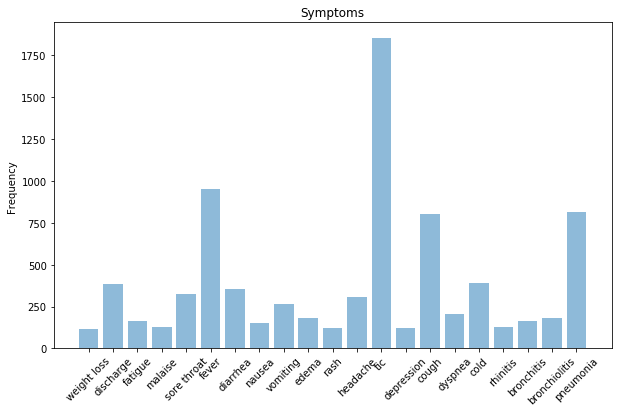

In [0]:
plt.figure(figsize=(10,6))
plt.bar(symp_df_plot.columns,symp_df_plot.iloc[1], align='center', alpha=0.5)
plt.xticks(symp_df_plot.columns,rotation=45)
plt.ylabel('Frequency')
plt.title('Symptoms')

plt.show()

### Association Analysis Using Apriori Algorithm

In [0]:
freq_items = apriori(symp_df, min_support=0.1, use_colnames=True, verbose=1)
freq_items.head(11)

Processing 15 combinations | Sampling itemset size 5


,support,itemsets
0,0.205472,(discharge)
1,0.174356,(sore throat)
2,0.509657,(fever)
3,0.189378,(diarrhea)
4,0.143777,(vomiting)
5,0.165236,(headache)
6,0.995172,(tic)
7,0.431330,(cough)
8,0.111588,(dyspnea)
9,0.210300,(cold)


In [0]:
rules = association_rules(freq_items, metric="confidence", min_threshold=0.2)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(fever),(discharge),0.509657,0.205472,0.143240,0.281053,1.367838,0.038520,1.105127
1,(discharge),(fever),0.205472,0.509657,0.143240,0.697128,1.367838,0.038520,1.618978
2,(discharge),(tic),0.205472,0.995172,0.204936,0.997389,1.002228,0.000456,1.849249
3,(tic),(discharge),0.995172,0.205472,0.204936,0.205930,1.002228,0.000456,1.000577
4,(discharge),(cough),0.205472,0.431330,0.140558,0.684073,1.585961,0.051932,1.800004


# 4.0 Insights about Policy and Guidance to Tackle the Outbreak

## Insights from Exploratory Data Analysis

The **incubation period** varies from 0 day to several months. Most of the researchers conclude the incubation period to be between 0 and 20 days. The most popular deduction would be between 0 and 10 days. It is suggested that people should self-isolate for two weeks after getting close to possible sources of infection to see if any symptoms appear and to avoid infecting others.

Coronavirus involve a number of **organs** of our body. The most related ones are liver, bronchi, spleen, brain, pons, eye, ear	and skin. Mild cases may not experience great challenges for their respiratory systems, however, severe cases can be in danger as many organs would be attacked. It is suggested that the government should gather medical resources and be prepared for the outbreak. Doctors and nurses should be familiarized with special practices treating the patients and dealing with the symptoms.

## Insights from Machine Learning Models



*   **Transmission**

  The coronavirus is highly infectious. The keywords retrieved by the LDA model reveal that the virus is transmitted by aerosols in the air and thus could transmit by contacting one another. Results also show that both human and animal can be infected. Wild animals such as bats are also hosts of the virus. In this case, it is suggested that the government should inform the public about the ways of transmission and methods to avoid infection, including social distancing, avoiding contacting with others, washing hands often, wearing facial masks and so on.



*   **Symptoms**

  The results from Apriori Algorithm show that tic, fever, cough, penumonia, cold, diarrhea, discharge, sore throat, headache, vomiting are the common symptoms of coronavirus. The association rule results show that discharge often appears with tic, fever or cough. Similarly, it is suggested that the government should inform the public about the common symptoms of coronavirus and the co-occurance of which of the symptoms is likely to be a coronavirus case and when they should go to the hospital or call the police.